### 데이터 불러오기

In [36]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from matplotlib import rcParams, font_manager

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [37]:
# train, test 데이터를 불러옵니다.
path = '/Users/yniyunj/Desktop/AI/250115-EVpriceprediction'
train = pd.read_csv(path+'/open/train.csv')
test = pd.read_csv(path+'/open/test.csv')

In [38]:
# 한글 폰트 파일 경로 지정
font_path = "/Users/yniyunj/Library/Fonts/NanumGothic-Regular.ttf"  # 설치된 폰트 경로
font_prop = font_manager.FontProperties(fname=font_path)

# Matplotlib 설정
rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

print("현재 설정된 폰트:", plt.rcParams['font.family'])

현재 설정된 폰트: ['NanumGothic']


In [39]:
train.head()

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
0,TRAIN_0000,P사,TayGTS,Nearly New,86.077,AWD,13642,0,No,2,159.66
1,TRAIN_0001,K사,Niro,Nearly New,56.000,FWD,10199,6,No,0,28.01
2,TRAIN_0002,A사,eT,Brand New,91.200,AWD,2361,7,No,0,66.27
3,TRAIN_0003,A사,RSeTGT,Nearly New,NaN,AWD,21683,3,No,0,99.16
4,TRAIN_0004,B사,i5,Pre-Owned,61.018,AWD,178205,1,No,0,62.02


### 데이터 살펴보기

In [40]:
def plot_histogram(data, columns_to_plot, cols=2, figsize=(10, 3)):
    # 해당 열이 데이터 내 존재하는 지 확인합니다.
    valid_columns = [col for col in columns_to_plot if col in data.columns]
    if not valid_columns:
        raise ValueError("해당 열이 존재하지 않습니다.")
    
    # 서브플롯을 생성하기 위해 행과 열의 수를 확인합니다.
    num_vars = len(valid_columns)
    rows = math.ceil(num_vars / cols)
    
    # 서브플롯을 생성합니다.
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()  
    
    for i, col in enumerate(valid_columns):
        sns.histplot(x=data[col], ax=axes[i])
        axes[i].set_title(col)
    
    # 빈 서브플롯을 삭제합니다.
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

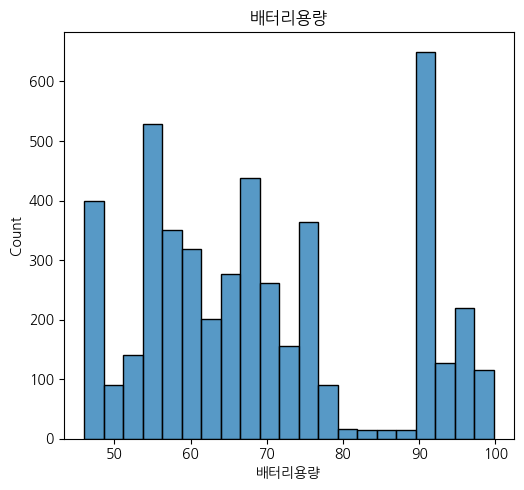

In [41]:
# 그래프를 생성할 열을 담은 리스트 입니다.
columns_to_plot = ['배터리용량']

# 선언한 함수를 사용하여 그래프를 생성합니다.
plot_histogram(data=train, columns_to_plot=columns_to_plot, cols=2, figsize=(10, 5))

In [42]:
train['배터리용량'].describe()

count    4786.000000
mean       69.397187
std        15.283635
min        46.000000
25%        56.359000
50%        68.125000
75%        78.227000
max        99.800000
Name: 배터리용량, dtype: float64

### Train 레이블 인코딩

In [43]:
encoded_train = train.copy()
# 범주형 열 확인
categorical_features = [col for col in encoded_train.columns if encoded_train[col].dtype == 'object']

# 레이블 인코딩 적용
for col in categorical_features:
    le = LabelEncoder()
    le.fit(encoded_train[col])
    encoded_train[col] = le.transform(encoded_train[col])
    
# 결과 확인
print(encoded_train.head())

   ID  제조사  모델  차량상태   배터리용량  구동방식  주행거리(km)  보증기간(년)  사고이력  연식(년)  가격(백만원)
0   0    4  16     1  86.077     0     13642        0     0      2   159.66
1   1    3  10     1  56.000     1     10199        6     0      0    28.01
2   2    0  17     0  91.200     0      2361        7     0      0    66.27
3   3    0  12     1     NaN     0     21683        3     0      0    99.16
4   4    1  19     2  61.018     0    178205        1     0      0    62.02


### Test 레이블인코딩

In [44]:
encoded_test = test.copy()
# 범주형 열 확인
categorical_features = [col for col in encoded_test.columns if encoded_test[col].dtype == 'object']

# 레이블 인코딩 적용
for col in categorical_features:
    le = LabelEncoder()
    le.fit(encoded_test[col])
    encoded_test[col] = le.transform(encoded_test[col])
    
# 결과 확인
print(encoded_test.head())

   ID  제조사  모델  차량상태   배터리용량  구동방식  주행거리(km)  보증기간(년)  사고이력  연식(년)
0   0    4  15     1  76.093     0     14057        2     0      0
1   1    1  20     0  90.000     0      7547        8     0      0
2   2    1  19     0     NaN     2      7197        7     1      0
3   3    2   2     1  68.479     0     10357        7     0      1
4   4    3   0     0     NaN     1      7597       10     0      0


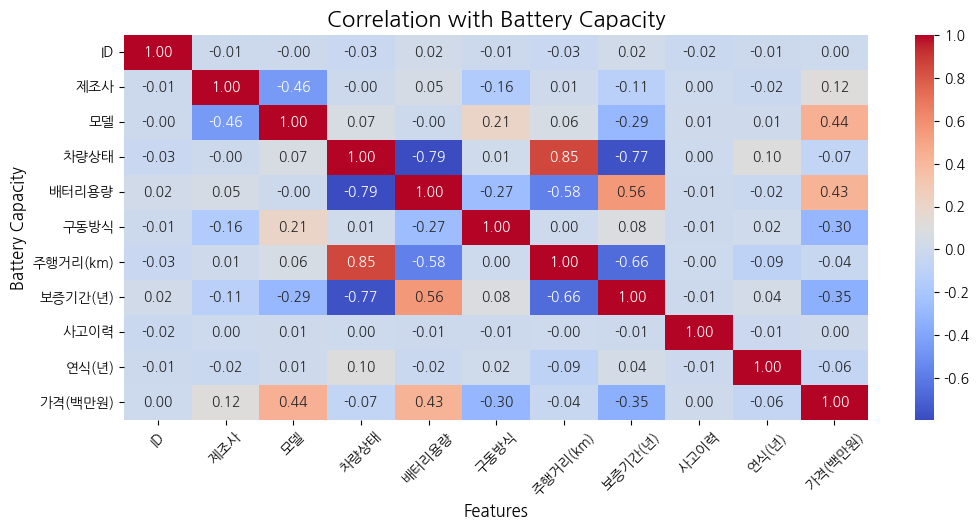

In [45]:
# '배터리용량'과 다른 변수 간의 상관계수 계산
battery_corr = encoded_train.corr()

# 상관계수 히트맵 시각화
plt.figure(figsize=(12, 5))
sns.heatmap(battery_corr.T, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation with Battery Capacity", fontsize=16)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Battery Capacity", fontsize=12)
plt.xticks(rotation=45)
plt.show()

### 결측값 채우기

- 배터리용량: 차량상태 -0.79, 주행거리(km) -0.58, 보증기간(년) 0.56
- 차량상태: 주행거리(km) 0.85, 보증기간(년) -0.77   

-> 차량상태와 보증기간(년)을 기준으로 배터리용량의 결측치를 그룹별 중앙값으로 채울거임

In [46]:
print(encoded_test['보증기간(년)'].describe())
print(encoded_test['보증기간(년)'].value_counts())

count    846.000000
mean       5.027187
std        3.157479
min        0.000000
25%        2.000000
50%        5.000000
75%        8.000000
max       10.000000
Name: 보증기간(년), dtype: float64
보증기간(년)
2     154
7     130
8     118
1      67
10     66
0      60
3      58
9      57
4      47
5      45
6      44
Name: count, dtype: int64


In [47]:
# 보증기간 구간화 및 결측치 채우기 함수
def process_data(encoded_data):
    # 보증기간(년)의 25%, 50%, 75% 계산
    quantiles = encoded_data['보증기간(년)'].quantile([0.25, 0.50, 0.75])
    q25, q50, q75 = quantiles[0.25], quantiles[0.50], quantiles[0.75]

    # 보증기간(년)을 구간화
    encoded_data['보증기간_구간'] = pd.cut(
        encoded_data['보증기간(년)'],
        bins=[-float('inf'), q25, q50, q75, float('inf')],
        labels=['25%', '50%', '75%', '100%']
    )

    # 차량상태와 보증기간 구간별 배터리용량 평균값 계산
    median_values = encoded_data.groupby(['차량상태', '보증기간_구간'], observed=True)['배터리용량'].mean().to_dict()

    # 결측치 채우기 함수
    def fill_missing_battery(row):
        if pd.isna(row['배터리용량']):
            return median_values.get((row['차량상태'], row['보증기간_구간']), row['배터리용량'])
        return row['배터리용량']

    # 결측치 채우기
    encoded_data['배터리용량'] = encoded_data.apply(fill_missing_battery, axis=1)

    return encoded_data

Train 결측치: 0
Test 결측치: 0


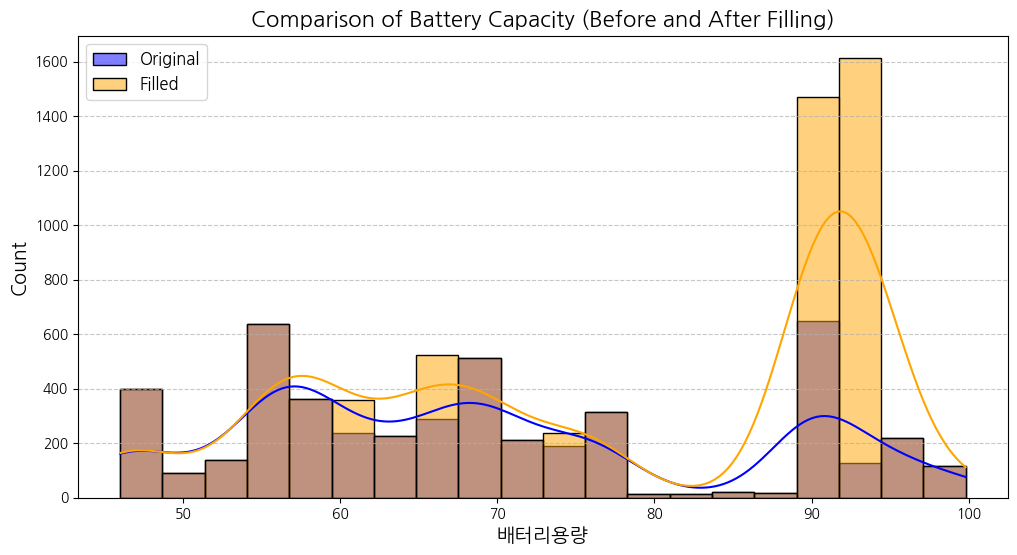

In [48]:
# 원본 데이터 복사 (결측치가 채워지기 전 데이터)
original_data = encoded_train.copy()

# 결측치 채우기
encoded_train = process_data(encoded_train)
encoded_test = process_data(encoded_test)

# 결측치 처리 결과 확인
print("Train 결측치:", encoded_train['배터리용량'].isna().sum())
print("Test 결측치:", encoded_test['배터리용량'].isna().sum())

# 그래프 비교
plt.figure(figsize=(12, 6))

# 원본 데이터의 히스토그램
sns.histplot(original_data['배터리용량'], bins=20, color='blue', kde=True, alpha=0.5, label='Original')

# 결측치 채운 데이터의 히스토그램
sns.histplot(encoded_train['배터리용량'], bins=20, color='orange', kde=True, alpha=0.5, label='Filled')

# 그래프 설정
plt.title('Comparison of Battery Capacity (Before and After Filling)', fontsize=16)
plt.xlabel('배터리용량', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [49]:
original_data.describe()

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
count,7497.000000,7497.000000,7497.000000,7497.000000,4786.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000
mean,3748.000000,2.746965,10.109377,0.823663,69.397187,0.452581,44287.979458,4.960918,0.045752,0.222489,62.331949
std,2164.341817,1.885991,6.286307,0.833279,15.283635,0.728974,55204.064386,3.155342,0.208960,0.569232,36.646759
min,0.000000,0.000000,0.000000,0.000000,46.000000,0.000000,3.000000,0.000000,0.000000,0.000000,9.000000
25%,1874.000000,1.000000,5.000000,0.000000,56.359000,0.000000,5465.000000,2.000000,0.000000,0.000000,34.390000
50%,3748.000000,3.000000,11.000000,1.000000,68.125000,0.000000,17331.000000,5.000000,0.000000,0.000000,56.000000
75%,5622.000000,4.000000,16.000000,2.000000,78.227000,1.000000,61252.000000,8.000000,0.000000,0.000000,80.050000
max,7496.000000,6.000000,20.000000,2.000000,99.800000,2.000000,199827.000000,10.000000,1.000000,2.000000,161.090000


In [50]:
encoded_train.describe()

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
count,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000
mean,3748.000000,2.746965,10.109377,0.823663,76.110615,0.452581,44287.979458,4.960918,0.045752,0.222489,62.331949
std,2164.341817,1.885991,6.286307,0.833279,16.278346,0.728974,55204.064386,3.155342,0.208960,0.569232,36.646759
min,0.000000,0.000000,0.000000,0.000000,46.000000,0.000000,3.000000,0.000000,0.000000,0.000000,9.000000
25%,1874.000000,1.000000,5.000000,0.000000,61.018000,0.000000,5465.000000,2.000000,0.000000,0.000000,34.390000
50%,3748.000000,3.000000,11.000000,1.000000,76.093000,0.000000,17331.000000,5.000000,0.000000,0.000000,56.000000
75%,5622.000000,4.000000,16.000000,2.000000,91.848750,1.000000,61252.000000,8.000000,0.000000,0.000000,80.050000
max,7496.000000,6.000000,20.000000,2.000000,99.800000,2.000000,199827.000000,10.000000,1.000000,2.000000,161.090000


In [51]:
encoded_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   ID        846 non-null    int64   
 1   제조사       846 non-null    int64   
 2   모델        846 non-null    int64   
 3   차량상태      846 non-null    int64   
 4   배터리용량     846 non-null    float64 
 5   구동방식      846 non-null    int64   
 6   주행거리(km)  846 non-null    int64   
 7   보증기간(년)   846 non-null    int64   
 8   사고이력      846 non-null    int64   
 9   연식(년)     846 non-null    int64   
 10  보증기간_구간   846 non-null    category
dtypes: category(1), float64(1), int64(9)
memory usage: 67.2 KB


### 데이터 전처리

In [52]:
# 학습과 예측을 위해 데이터를 분리합니다.
x_train = encoded_train.drop(['ID', '보증기간_구간', '가격(백만원)'], axis = 1)
y_train = encoded_train['가격(백만원)']

x_test = encoded_test.drop(['ID', '보증기간_구간'], axis = 1)

### 학습 및 예측하기

In [53]:
# 사용할 모델 리스트
models = {
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(),
    "GradientBoosting": GradientBoostingRegressor(),
    "LinearRegression": LinearRegression(),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(),
    "LightGBM": LGBMRegressor(verbose=0),
    "CatBoost": CatBoostRegressor(verbose=0),  # CatBoost의 출력 제한
    "XGBoost": XGBRegressor(verbosity=0)  # XGBoost의 출력 제한
}

# RMSE를 스코어로 사용할 수 있도록 정의
rmse_scorer = make_scorer(root_mean_squared_error)

# 성능 결과를 저장할 딕셔너리
results = {}

# 반복문으로 모델 학습 및 평가 (교차 검증)
for name, model in models.items():
    print(f"Evaluating {name}...")
    # 교차 검증으로 성능 평가 (5-Fold)
    scores = cross_val_score(model, x_train, y_train, cv=5, scoring=rmse_scorer)
    results[name] = np.mean(scores)
    print(f"{name} Mean RMSE: {np.mean(scores):.4f}")

# 결과 출력
print("\n모델별 교차 검증 Mean RMSE:")
for name, rmse in results.items():
    print(f"{name}: {rmse:.4f}")

Evaluating DecisionTree...
DecisionTree Mean RMSE: 1.8461
Evaluating RandomForest...
RandomForest Mean RMSE: 1.4892
Evaluating GradientBoosting...
GradientBoosting Mean RMSE: 3.0068
Evaluating LinearRegression...
LinearRegression Mean RMSE: 21.4471
Evaluating SVR...
SVR Mean RMSE: 37.4665
Evaluating KNN...
KNN Mean RMSE: 37.9743
Evaluating LightGBM...
LightGBM Mean RMSE: 1.4103
Evaluating CatBoost...
CatBoost Mean RMSE: 1.3846
Evaluating XGBoost...
XGBoost Mean RMSE: 1.4319

모델별 교차 검증 Mean RMSE:
DecisionTree: 1.8461
RandomForest: 1.4892
GradientBoosting: 3.0068
LinearRegression: 21.4471
SVR: 37.4665
KNN: 37.9743
LightGBM: 1.4103
CatBoost: 1.3846
XGBoost: 1.4319


In [54]:
# 모델을 선언하고, 학습을 진행합니다.
model = CatBoostRegressor(verbose=0)
model.fit(x_train, y_train)

In [55]:
# 예측을 수행합니다.
pred = model.predict(x_test)

### 제출하기

In [56]:
# sample_submission 파일을 불러옵니다.
submit = pd.read_csv(path+'/open/sample_submission.csv')

# 예측한 결과를 submit에 저장합니다.
submit['가격(백만원)'] = pred
submit.head()

,ID,가격(백만원)
0,TEST_000,130.220198
1,TEST_001,79.988374
2,TEST_002,64.799039
3,TEST_003,34.871796
4,TEST_004,47.974041


In [57]:
# 제출을 위해 baseline_submission.csv란 이름으로 CSV 파일을 저장합니다.
submit.to_csv(path+'/submission/240118-pred12.csv',index=False)